In [288]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [289]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

import warnings
warnings.filterwarnings("ignore")

In [290]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [291]:
path_result = "Data/Data100/Results/"
path_output = "Data/Data100/Output/"

In [292]:
imp_file_list = [f for f in os.listdir(path_result) if os.path.splitext(f)[-1]==".pkl" if "imp" in f]
# len(imp_file_list)

In [293]:
res_file_list = [f for f in os.listdir(path_result) if os.path.splitext(f)[-1]==".pkl" if "imp" not in f]
# len(res_file_list)

In [294]:
converge = {}
df_zero = pd.DataFrame()
df_imp = pd.DataFrame()
for f in imp_file_list:
    
    ds = os.path.splitext(f)[0].split("_")[-1]
    
    # convergence
    converge_key = ds
    df_temp = pd.read_pickle(path_result + f)
    converge_value = df_temp.Iteration.max()
    converge.update({converge_key:converge_value})
    
    # Top 4 important features
    df_temp["DS"] = ds 
    df_imp = pd.concat([df_imp, df_temp], ignore_index=True)
    
    
    # Zero Count
    df_temp_zero = df_temp.groupby("Iteration", as_index=False)["Zero_Count"].sum()
    df_temp_zero["DS"] = ds 
    df_zero = pd.concat([df_zero, df_temp_zero], ignore_index = True)

In [295]:
df_r2 = pd.DataFrame()
for f in res_file_list:
    
    ds = os.path.splitext(f)[0].split("_")[-1]
    
    with open(path_result + f, "rb") as file:
        r = pickle.load(file)
    
    # R2
    df_temp = pd.DataFrame({"Iteration":[i[0] for i in r],
                            "R2":[j[3]["r2"] for j in r],
                           "Importance":[k[2] for k in r]})
                            
    df_temp["DS"] = ds 
    df_r2 = pd.concat([df_r2, df_temp], ignore_index = True)

In [296]:
df_r2["DS"] = df_r2["DS"].astype("int")
df_r2.sort_values(["DS", "Iteration"], inplace=True)

In [297]:
df_r3 = df_r2.copy()
df_r4 = df_r2.copy()
df_r5 = df_r2.copy()
df_r10 = df_r2.copy()

In [298]:
df_r2["Top2"] = df_r2.Importance.apply(lambda x: x[:2])
df_r2["Top2_shifted"] = df_r2["Top2"].shift()
df_r2 = df_r2[df_r2["Iteration"]!=0]  

df_r2["Top2_converge"] = df_r2["Top2"] == df_r2["Top2_shifted"]

df_r2_converge = df_r2[df_r2["Top2_converge"]].groupby("DS", as_index=False).first() 

In [299]:
df_r3["Top3"] = df_r3.Importance.apply(lambda x: x[:3])
df_r3["Top3_shifted"] = df_r3["Top3"].shift()
df_r3 = df_r3[df_r3["Iteration"]!=0]  

df_r3["Top3_converge"] = df_r3["Top3"] == df_r3["Top3_shifted"]

df_r3_converge = df_r3[df_r3["Top3_converge"]].groupby("DS", as_index=False).first() 

In [300]:
df_r4["Top4"] = df_r4.Importance.apply(lambda x: x[:4])
df_r4["Top4_shifted"] = df_r4["Top4"].shift()
df_r4 = df_r4[df_r4["Iteration"]!=0]  

df_r4["Top4_converge"] = df_r4["Top4"] == df_r4["Top4_shifted"]

df_r4_converge = df_r4[df_r4["Top4_converge"]].groupby("DS", as_index=False).first() 

In [301]:
dif_4 = df_r2_converge.index.difference(df_r4_converge.index).tolist()

In [302]:
df_r4_converge.loc[dif_4[0], "Iteration"] = 19

In [303]:
df_r5["Top5"] = df_r5.Importance.apply(lambda x: x[:5])
df_r5["Top5_shifted"] = df_r5["Top5"].shift()
df_r5 = df_r5[df_r5["Iteration"]!=0]  

df_r5["Top5_converge"] = df_r5["Top5"] == df_r5["Top5_shifted"]

df_r5_converge = df_r5[df_r5["Top5_converge"]].groupby("DS", as_index=False).first() 

dif_5 = df_r2_converge.index.difference(df_r5_converge.index).tolist()

for i in dif_5:
    df_r5_converge.loc[i, "Iteration"] = 19

In [304]:
df_r10["Top10"] = df_r10.Importance.apply(lambda x: x[:10])
df_r10["Top10_shifted"] = df_r10["Top10"].shift()
df_r10 = df_r10[df_r10["Iteration"]!=0]  

df_r10["Top10_converge"] = df_r10["Top10"] == df_r10["Top10_shifted"]

df_r10_converge = df_r10[df_r10["Top10_converge"]].groupby("DS", as_index=False).first() 

dif_10 = df_r2_converge.index.difference(df_r10_converge.index).tolist()

for i in dif_10:
    df_r10_converge.loc[i, "Iteration"] = 19

In [305]:
df_converge = pd.DataFrame(converge.values(), index= converge.keys())
df_converge.columns = ["Converge"]
# df_converge

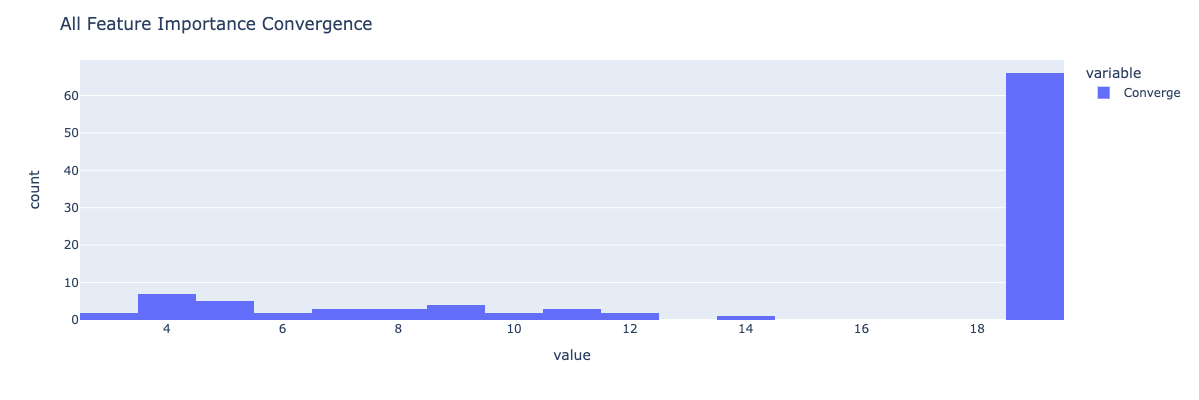

In [307]:
fig = px.histogram(df_converge["Converge"], nbins = 20)

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text=f"All Feature Importance Convergence"
)

fig.show()

In [198]:
# fig = px.histogram(df_r2_converge.Iteration, nbins = 20)
# 
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=400,
#     title_text=f"Top 2 Feature Importance Convergence"
# )
# 
# fig.show()

In [199]:
# fig = px.histogram(df_r3_converge.Iteration, nbins = 20)
# 
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=400,
#     title_text=f"Top 3 Feature Importance Convergence"
# )
# 
# fig.show()

In [200]:
# fig = px.histogram(df_r4_converge.Iteration, nbins = 20)
# 
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=400,
#     title_text=f"Top 4 Feature Importance Convergence"
# )
# 
# fig.show()

In [201]:
# fig = px.histogram(df_r5_converge.Iteration, nbins = 20)
# 
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=400,
#     title_text=f"Top 5 Feature Importance Convergence"
# )
# 
# fig.show()

In [202]:
# fig = px.histogram(df_r10_converge.Iteration, nbins = 20)
# 
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=400,
#     title_text=f"Top 10 Feature Importance Convergence"
# )
# 
# fig.show()

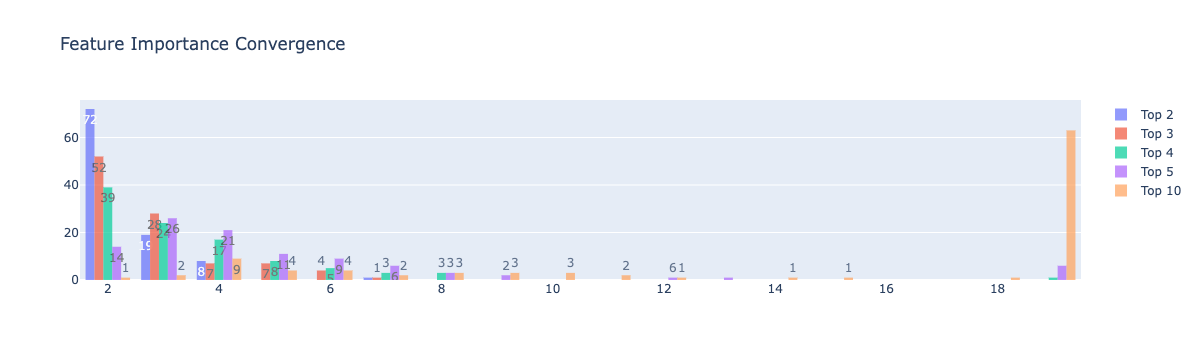

In [287]:
fig = go.Figure()

fig.add_trace(go.Histogram(x= df_r2_converge.Iteration.values, name='Top 2', text=df_r2_converge.Iteration.value_counts().sort_index()))
fig.add_trace(go.Histogram(x= df_r3_converge.Iteration.values, name='Top 3', text=df_r3_converge.Iteration.value_counts().sort_index()))
fig.add_trace(go.Histogram(x= df_r4_converge.Iteration.values, name='Top 4', text=df_r4_converge.Iteration.value_counts().sort_index()))
fig.add_trace(go.Histogram(x= df_r5_converge.Iteration.values, name='Top 5', text=df_r5_converge.Iteration.value_counts().sort_index()))
fig.add_trace(go.Histogram(x= df_r10_converge.Iteration.values, name='Top 10', text=df_r10_converge.Iteration.value_counts().sort_index()))
              
fig.update_layout(barmode='group', title_text='Feature Importance Convergence')
fig.update_traces(opacity=0.7)

fig.show()

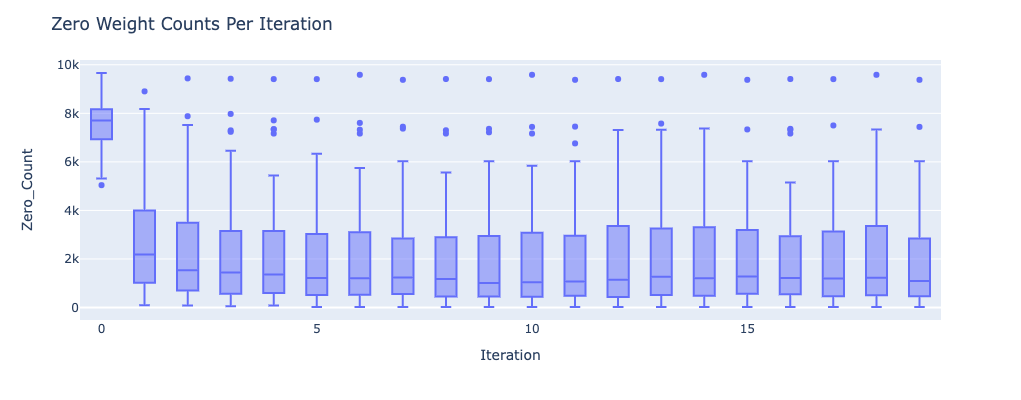

In [13]:
fig = px.box(df_zero, x = "Iteration", y = "Zero_Count", hover_data = ["DS"])

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"Zero Weight Counts Per Iteration"
)

fig .show()

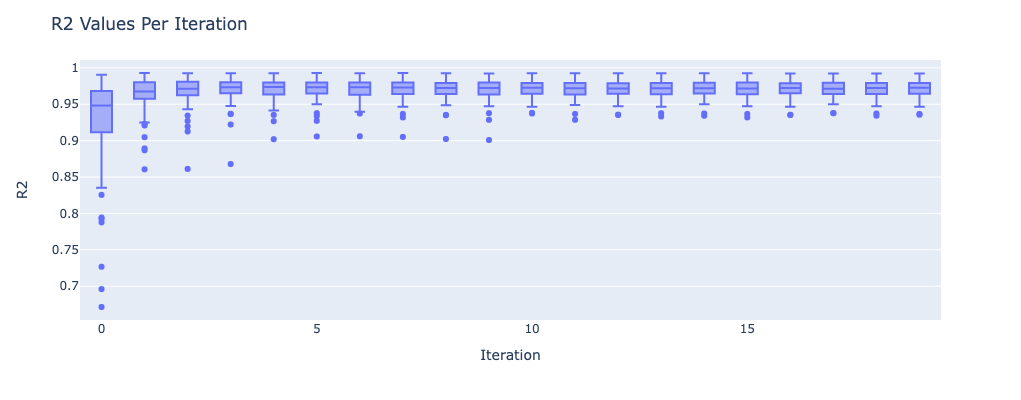

In [14]:
fig = px.box(df_r2, x = "Iteration", y = "R2", hover_data = ["DS"])

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"R2 Values Per Iteration"
)

fig .show()

In [218]:
df_imp_1 = df_imp[~df_imp["Feature Name"].str.contains("Output")].sort_values(["DS", "Iteration", "Importance"], ascending=[True, True, False])

In [219]:
df_imp_1["Rank"] = df_imp_1.groupby(["DS", "Iteration"])["Importance"].rank(ascending=False).astype("int")

In [220]:
df_imp_2 = df_imp_1.groupby(["DS", "Iteration"], as_index=False).head(4)
# df_imp_2

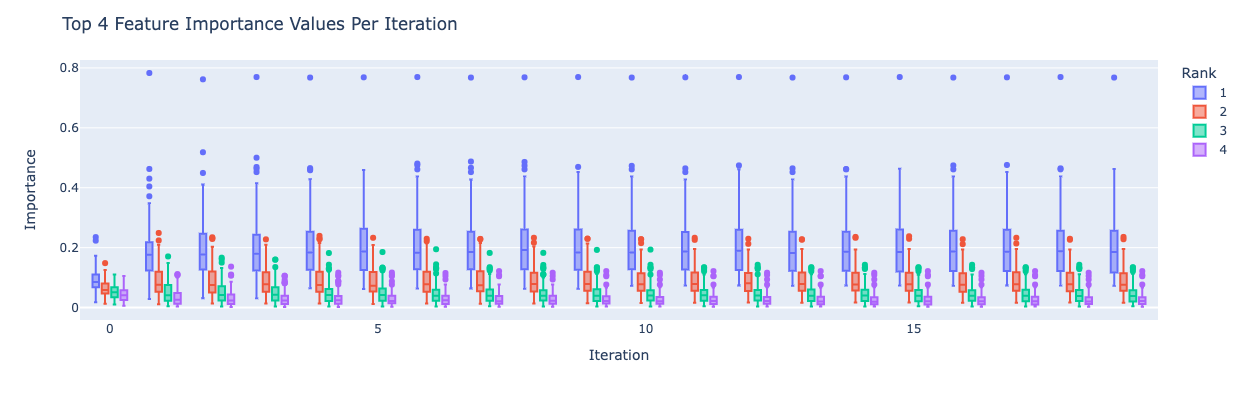

In [221]:
fig = px.box(df_imp_2, x = "Iteration", y = "Importance", hover_data = ["DS"], color="Rank")

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"Top 4 Feature Importance Values Per Iteration"
)

fig .show()

In [222]:
# len([f for f in os.listdir(path_output) if os.path.isdir(path_output + f)])

In [223]:
folders = [path_output + f for f in os.listdir(path_output) if os.path.isdir(path_output + f)]

In [201]:
df_es = pd.DataFrame()

for file in folders:
    #print(file)
    df_q = pd.read_excel(os.path.join(file, "US12I1O_Sol.xlsx"), index_col=0, usecols="A:B", sheet_name=None)
    
    for el in df_q.keys():

        df_temp = pd.DataFrame({"Iteration":[el.split("_")[-1]],
                         "# of Efficient DMU":(df_q[el]==1).sum().values,
                         "DS":[file.split("_")[-1]]})

        df_es = pd.concat([df_es,df_temp], ignore_index=True)

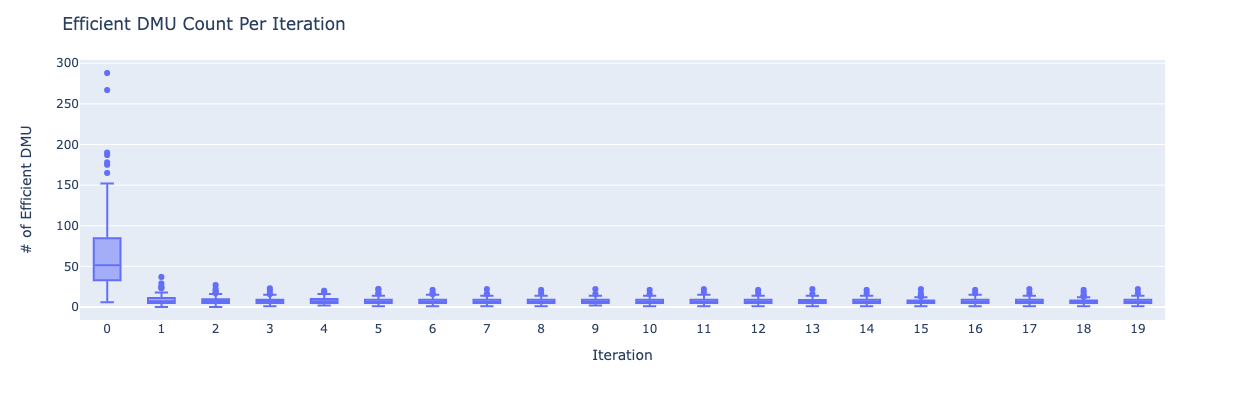

In [224]:
fig = px.box(df_es, x = "Iteration", y = "# of Efficient DMU", hover_data = ["DS"])

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"Efficient DMU Count Per Iteration"
)

fig .show()